# Machine Learning Exercise

Now it's time to practice what you have seen in the previous notebooks. Your task for today is to download the data from the database and train a model in order to predict if a patient has a heart disease or not. 

![](https://www.nicepng.com/png/detail/397-3975460_disease-high-quality-png-heart-disease-cartoon-png.png)

## Task:

1. Import the data from the database. The schema is called `heart`. You can use DBeaver to get an overview over the different tables and think about a good way to join them. 
2. Conduct a brief EDA to become familiar with the data. 
3. Preprocess the data as far as you need it and...
4. ...train a logistic regression model.

## What you should use/keep in mind:
 
* **Scale your data:** Which scaler works best in your case?
* **Tune your model:** Tune the hyperparameter of your model. You can start with a larger parameter grid and a `RandomizedSearchCV` and continue with a narrower parameter grid for your `GridSearchCV`.
* **Choose the right evaluation metric!**


## Data Overview

| column | additional information |
|--------|------------------------|
| age | age of patient |
| sex | gender of patient |
| chest_pain_type  | 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic | 
| resting_blood_pressure |  | 
| fasting_blood_sugar | > 120 mg/dl, 1 = true, 0 = false | 
| thal | 0 = normal, 1 = fixed defect, 2 = reversable defect
| serum_cholestoral | in mg/dl | 
| resting_electrocardiographic_results | 0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria | 
| maximum_heartrate_achieved | | 
| exercise_induced_angina | 1 = yes, 0 = no | 
| oldpeak | ST depression induced by exercise relative to rest | 
| slope_of_the_peak_exercise_st_segment | 1= upsloping, 2 = flat, 3 = downsloping | 
| number_of_major_vessels_colored_by_flourosopy | |
| real_data | tag to distinguish between real and made up data | 
| heart_attack | 0 = little risk of heart attack, 1 = high risk of heart attack | 

## Import

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# Feel free to add all the libraries you need

## Getting the Data

The data for this exercise is stored in our postgres database in the schema `heart`. The different features are split thematically into five different tables. Your first task will be to have a look at the tables (e.g. in DBeaver) and figure out a way to join the information you need. As soon as you're happy with your query, you can use the following code cells to import the data into this notebook. 

In previous notebooks you've seen two different approaches to import data from a database into a notebook. The following code will use `sqlalchemy`in combination with pandas `pd.read_sql()` function. For the code to work, you need to copy the `.env` file from the previous repositories into this repository and change the query_string to your own query.

In [2]:
# Read database string from .env file (no need to change anything)
#load_dotenv()

#DB_STRING = os.getenv('DB_STRING')

#db = create_engine(DB_STRING)

In [3]:
# Define query to download data (add your query here)
query_string = """
                SET SCHEMA 'heart';
                SELECT *
                FROM heart.patient AS p
                LEFT JOIN heart.pressure_vessels_angina AS pva ON pva.patient_id = p.id
                LEFT JOIN heart.chest_pain AS cp ON cp.patient_id = p.id
                LEFT JOIN heart.heart_attack_history AS hah ON hah.patient_id = p.id
                LEFT JOIN heart.blood_metrics AS bm ON bm.patient_id = p.id
                WHERE pva.real_data <> 'Evgeny likes white wine for lunch and red wine for dinner'
                OR pva.real_data IS NULL
                ORDER BY p.id ASC;"""

# Import with pandas
#df_sqlalchemy = pd.read_sql(query_string, db)
#df_sqlalchemy.head()

In [4]:
# Save dataframe as .csv file
#df_sqlalchemy.to_csv("heart_data.csv", index=False)

In [5]:
df = pd.read_csv("heart_data.csv")

In [6]:
df.columns

Index(['id', 'age', 'sex', 'resting_blood_pressure',
       'resting_electrocardiographic_results', 'maximum_heartrate_achieved',
       'exercise_induced_angina', 'oldpeak',
       'slope_of_the_peak_exercise_st_segment',
       'number_of_major_vessels_colored_by_flourosopy', 'patient_id', 'id.1',
       'real_data', 'chest_pain_type', 'patient_id.1', 'id.2', 'heart_attack',
       'patient_id.2', 'id.3', 'serum_cholestoral', 'fasting_blood_sugar',
       'thal', 'patient_id.3', 'id.4'],
      dtype='object')

In [7]:
df.shape

(353, 24)

In [8]:
df = df.drop(['id','patient_id', 'id.1','patient_id.1', 'id.2','patient_id.2', 'id.3', 'patient_id.3', 'id.4'], axis = 1)

In [9]:
df.isnull().sum()

age                                               10
sex                                               19
resting_blood_pressure                            50
resting_electrocardiographic_results              50
maximum_heartrate_achieved                        61
exercise_induced_angina                           50
oldpeak                                           50
slope_of_the_peak_exercise_st_segment             50
number_of_major_vessels_colored_by_flourosopy     50
real_data                                        110
chest_pain_type                                   50
heart_attack                                       0
serum_cholestoral                                 50
fasting_blood_sugar                               50
thal                                              50
dtype: int64

In [10]:
df.loc[:, "real_data"] = df["real_data"].notna().astype(int)

In [11]:
df.loc[:, "real_data"] = df["real_data"].astype(int)

In [12]:
numerical_columns = ['age', 'resting_blood_pressure','maximum_heartrate_achieved', 'oldpeak',
                     'number_of_major_vessels_colored_by_flourosopy','serum_cholestoral']

In [13]:
categorical_columns = ['sex','resting_electrocardiographic_results','exercise_induced_angina',
       'slope_of_the_peak_exercise_st_segment','real_data',
       'chest_pain_type','heart_attack', 'fasting_blood_sugar', 'thal']

<Axes: >

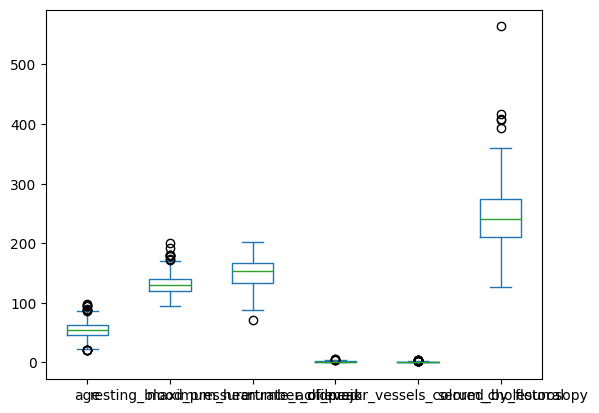

In [14]:
df[numerical_columns].plot(kind="box")

<Axes: ylabel='Density'>

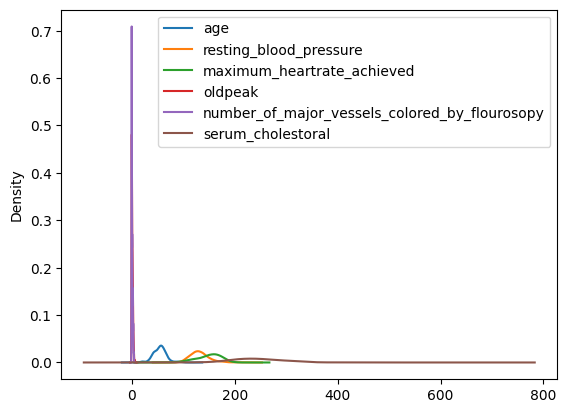

In [15]:
df[numerical_columns].plot(kind="kde")

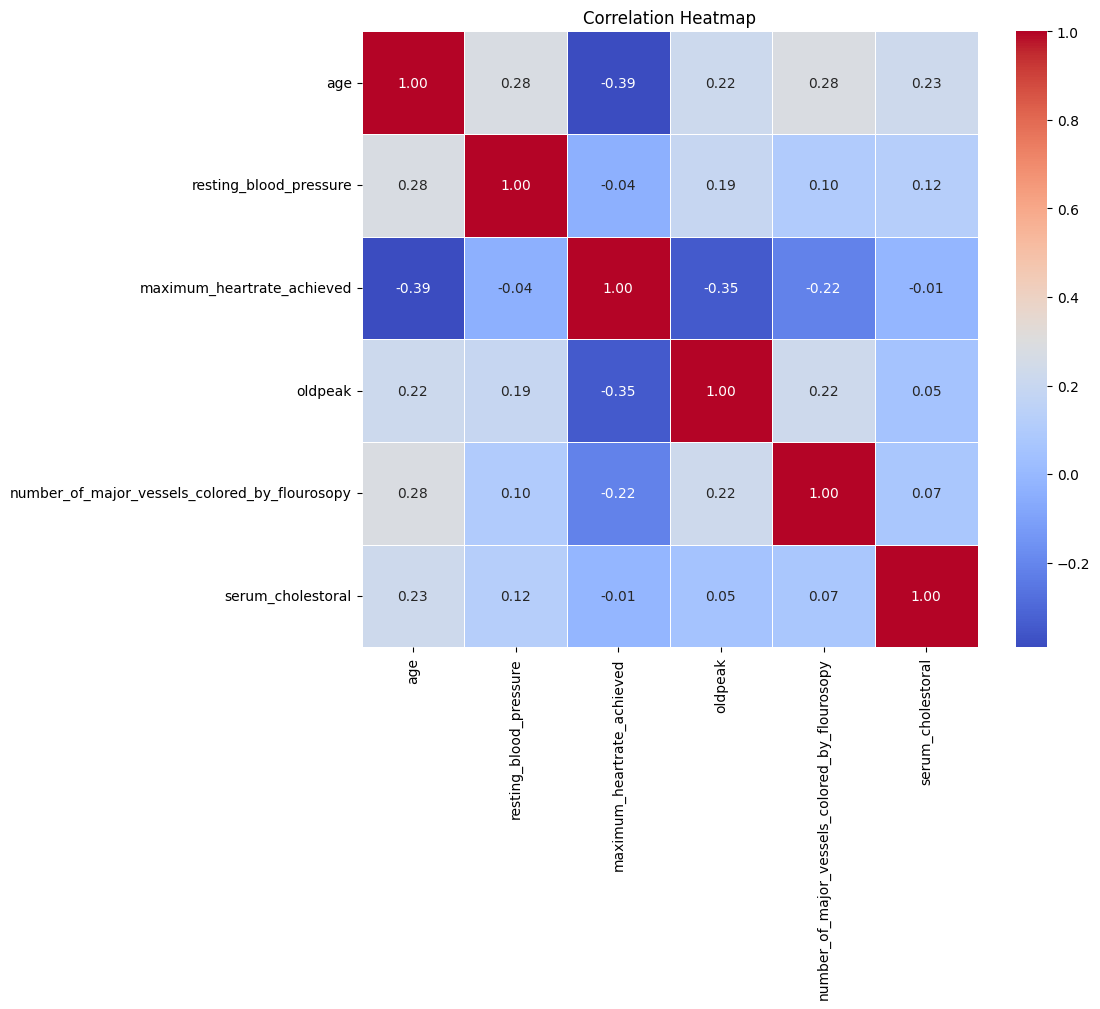

In [16]:
corr = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)
plt.title("Correlation Heatmap")
plt.show()

In [17]:
imputer = SimpleImputer(strategy="median")
df.loc[:, numerical_columns] = imputer.fit_transform(df[numerical_columns])

imputer2 = SimpleImputer(strategy="most_frequent")
df.loc[:, categorical_columns] = imputer2.fit_transform(df[categorical_columns])

In [18]:
df[categorical_columns] = df[categorical_columns].astype(int)

In [19]:
df.dtypes

age                                              float64
sex                                                int64
resting_blood_pressure                           float64
resting_electrocardiographic_results               int64
maximum_heartrate_achieved                       float64
exercise_induced_angina                            int64
oldpeak                                          float64
slope_of_the_peak_exercise_st_segment              int64
number_of_major_vessels_colored_by_flourosopy    float64
real_data                                          int64
chest_pain_type                                    int64
heart_attack                                       int64
serum_cholestoral                                float64
fasting_blood_sugar                                int64
thal                                               int64
dtype: object

In [20]:
df.isnull().sum()

age                                              0
sex                                              0
resting_blood_pressure                           0
resting_electrocardiographic_results             0
maximum_heartrate_achieved                       0
exercise_induced_angina                          0
oldpeak                                          0
slope_of_the_peak_exercise_st_segment            0
number_of_major_vessels_colored_by_flourosopy    0
real_data                                        0
chest_pain_type                                  0
heart_attack                                     0
serum_cholestoral                                0
fasting_blood_sugar                              0
thal                                             0
dtype: int64

In [21]:
# Define predictors and target
y = df.heart_attack
X = df.drop('heart_attack', axis=1)

In [22]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
# Scaling with standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled = scaler.transform(X_test[numerical_columns])

In [24]:
# Concatenating scaled and dummy columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(numerical_columns, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test.drop(numerical_columns, axis=1)], axis=1)

In [25]:
# Fit and evaluate model without hyperparameter tuning using cross validation and unscaled data 
log_reg = LogisticRegression(max_iter=1000)
scores = cross_val_score(log_reg, X_train, y_train, cv=5, n_jobs=-1)

# Evaluation 
print('Score (unscaled):', round(scores.mean(), 4))

Score (unscaled): 0.7873


In [26]:
# Fit and evaluate model without hyperparameter tuning using cross validation and scaled data 
log_reg2 = LogisticRegression(max_iter=1000)
scores_scaled = cross_val_score(log_reg2, X_train_preprocessed, y_train, cv=5, n_jobs=-1)

# Evaluation
print('Score (scaled):', round(scores_scaled.mean(), 4))

Score (scaled): 0.7908


In [27]:
# Define parameter grid for randomized search
#param_grid = {
#    "C": np.logspace(-4, 4, 20),      # 20 values from 1e-4 to 1e4
#    "penalty": ["l2", None], # l1 requires solver='saga'
#   "solver": ["lbfgs", "saga"],     # solvers
#    "class_weight": [None, "balanced"]
#}

param_grid = [
    # L2 penalty (C matters)
    {
        "penalty": ["l2"],
        "solver": ["lbfgs", "saga"],
        "C": np.logspace(-4, 4, 20),
        "class_weight": [None, "balanced"]
    },
    # No regularization (C ignored)
    {
        "penalty": [None],
        "solver": ["lbfgs", "sag", "saga"],
        "class_weight": [None, "balanced"]
    }
]

# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_grid, scoring='f1',
                  cv=5, verbose=5, n_iter=30, n_jobs=-1, random_state=10)

# Fit randomized search object to data
rs.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,LogisticRegre...max_iter=1000)
,param_distributions,"[{'C': array([1.0000...00000000e+04]), 'class_weight': [None, 'balanced'], 'penalty': ['l2'], 'solver': ['lbfgs', 'saga']}, {'class_weight': [None, 'balanced'], 'penalty': [None], 'solver': ['lbfgs', 'sag', ...]}]"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,5
,pre_dispatch,'2*n_jobs'
,random_state,10
,error_score,nan


In [28]:
# Best score
print('Best score:', round(rs.best_score_, 3))

# Best parameters
print('Best parameters:', rs.best_params_)

Best score: 0.817
Best parameters: {'solver': 'saga', 'penalty': 'l2', 'class_weight': None, 'C': np.float64(4.281332398719396)}


In [29]:
# Assigning the fitted KNNClassifier model with best parameter combination to a new variable knn_best
log_reg_best_rs = rs.best_estimator_

# Making predictions on the test set
y_pred_test_rs = log_reg_best_rs.predict(X_test_preprocessed)

In [30]:
confusion_matrix(y_test, y_pred_test_rs)

array([[24,  9],
       [ 3, 35]])

In [31]:
accuracy_score(y_test, y_pred_test_rs)

0.8309859154929577